In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

C:\Users\kearn\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Read the csv into a DataFrame
df = pd.read_csv('predictorvariablewithSprayLeaguess.csv')

In [4]:
# Replace 'HitbyPitch' with 'HitByPitch' in the 'Events' column
df['Events'] = df['Events'].replace('HitbyPitch', 'HitByPitch')
df['Events'] = df['Events'].replace('Hitbypitch', 'HitByPitch')
df['Events'] = df['Events'].replace('StirkeCalled', 'StrikeCalled')

df = df[~df['Events'].isin(['FieldersChoice'])]

# Now you can check the unique values again to confirm the change
print(df['Events'].unique())

['StrikeCalled' 'BallCalled' 'Strikeout' 'FoulBall' 'Single'
 'StrikeSwinging' 'Double' 'Walk' 'Sacrifice' 'Out' 'HitByPitch' 'HomeRun'
 'Error' 'Triple' 'BallinDirt' 'BallIntentional' 'StolenBase'
 'CaughtStealing']


In [5]:
df = df[~df['TaggedPitchType'].isin(['Undefined', 'Other', 'Knuckleball'])]

# Create a Count column that combines Balls and Strikes
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

#events unique values
df['TaggedPitchType'].unique()

array(['Fastball', 'Slider', 'ChangeUp', 'Curveball', 'Cutter', 'Sinker',
       'Splitter', 'FourSeamFastBall', 'TwoSeamFastBall',
       'OneSeamFastBall'], dtype=object)

In [6]:
BallCalled = 0.081127
BallIntentional = -0.001517
BallinDirt = 0.115001
CaughtStealing = -0.554945
FoulBall = -0.06405
HitByPitch = 0.456369
StolenBase = 0.193517
StrikeCalled = -0.089088
StrikeSwinging = -0.096909
Strikeout = -0.307989


Error = 0.023050
FieldersChoice = -0.145975
HomeRun = 0.891016
Walk = 0.244294
Out = -0.136665
Sacrifice = -0.109899
Single = 0.268356
Triple = 0.363789
Double = 0.437576

# Map the defined run values to the corresponding events for df
df['RunValue'] = df['Events'].map({
    'BallCalled': BallCalled,
    'BallinDirt': BallinDirt,
    'Double': Double,
    'FoulBall': FoulBall,
    'HitByPitch': HitByPitch,
    'HomeRun': HomeRun,
    'Out': Out,
    'Single': Single,
    'StrikeCalled': StrikeCalled,
    'StrikeSwinging': StrikeSwinging,
    'Triple': Triple
})

# Display unique values in the 'RunValue' column
unique_values = df['RunValue'].unique()
print(unique_values)

[-0.089088  0.081127       nan -0.06405   0.268356 -0.096909  0.437576
 -0.136665  0.456369  0.891016  0.363789  0.115001]


In [7]:
# Remove rows with nan in the 'RunValue' column
df = df.dropna(subset=['RunValue'])
df['TaggedPitchType'].unique()

array(['Fastball', 'Slider', 'ChangeUp', 'Curveball', 'Cutter', 'Sinker',
       'Splitter', 'FourSeamFastBall', 'TwoSeamFastBall',
       'OneSeamFastBall'], dtype=object)

In [8]:
# Round the 'RelSpeed' column to 1 decimal place
df['RelSpeed'] = df['RelSpeed'].round(1)
df['InducedVertBreak'] = df['InducedVertBreak'].round(1)
df['HorzBreak'] = df['HorzBreak'].round(1)
df['RelHeight'] = df['RelHeight'].round(1)
df['RelSide'] = df['RelSide'].round(1)
df['Extension'] = df['Extension'].round(1)


df['year'] = pd.to_datetime(df['Date']).dt.year

# 2. Create dummy variables for the extracted year
year_dummies = pd.get_dummies(df['year'], prefix='year')

# 3. Merge the dummy variables back to the original dataframes
df = pd.concat([df, year_dummies], axis=1)

# Assuming 'sec_teams' is a list of the SEC team codes
sec_teams = [
    "ALA_CRI", "ARK_RAZ", "AUB_TIG", "FLA_GAT", "GEO_BUL",
    "KEN_WIL", "LSU_TIG", "MIZ_TIG", "MSU_BDG", "OLE_REB",
    "TEN_VOL", "TEX_AGG", "VAN_COM", "SOU_GAM"
]

# Add a binary column indicating SEC game where both pitcher and batter teams are SEC teams
df['SEC_Game'] = df.apply(lambda row: int(row['PitcherTeam'] in sec_teams and row['BatterTeam'] in sec_teams), axis=1)

# Filtering and creating copies
dfb3 = df[df.TaggedPitchType.isin(['Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'])].copy()
dsl3 = df[df.TaggedPitchType.isin(['Slider', 'Cutter', 'Curveball'])].copy()
dch3 = df[df.TaggedPitchType.isin(['ChangeUp', 'Splitter'])].copy()

# Define the larger strike zone
larger_strike_zone = {
    'xmin': -9.97/12 - 2.00/12,
    'xmax': 9.97/12 + 2.00/12,
    'ymin': 18.00/12 - 1.47/12,
    'ymax': 40.53/12 + 1.47/12
}

# Function to check if a pitch is in the larger strike zone
def is_in_zone(row):
    return int(larger_strike_zone['xmin'] <= row['RelSide'] <= larger_strike_zone['xmax'] and
               larger_strike_zone['ymin'] <= row['RelHeight'] <= larger_strike_zone['ymax'])

# Add the binary variable 'in_zone' to the dataframes
for df in [dfb3, dsl3, dch3]:
    df['in_zone'] = df.apply(is_in_zone, axis=1)

# Calculate the average fastball speed for each pitcher
avg_speed = dfb3.groupby('Pitcher')['RelSpeed'].mean().reset_index()
avg_speed.columns = ['Pitcher', 'AvgFastballSpeed']

# Merge this average speed with dsl2 and dch2
dsl3 = dsl3.merge(avg_speed, on='Pitcher', how='left')
dch3 = dch3.merge(avg_speed, on='Pitcher', how='left')

# Calculate velo_diff for dsl2 and dch2
dsl3['velo_diff'] = dsl3['AvgFastballSpeed'] - dsl3['RelSpeed']
dch3['velo_diff'] = dch3['AvgFastballSpeed'] - dch3['RelSpeed']

# Adding new columns
for df in [dfb3, dsl3, dch3]:
    df['bats_r'] = df['BatterSide'].apply(lambda x: 1 if x == 'Right' else 0)
    df['throws_r'] = df['PitcherThrows'].apply(lambda x: 1 if x == 'Right' else 0)

# Compute movement differentials for dsl2 and dch2 using all fastballs
for df in [dsl3, dch3]:
    df['ivb_fb_diff'] = abs(df['InducedVertBreak'] - dfb3['InducedVertBreak'].mean())
    df['hb_fb_diff'] = abs(df['HorzBreak'] - dfb3['HorzBreak'].mean())

# Remove rows with NaN in specified columns
dfb3 = dfb3.dropna(subset=['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension'])
dsl3 = dsl3.dropna(subset=['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'velo_diff', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension'])
dch3 = dch3.dropna(subset=['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'velo_diff', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension'])

# Print the shape of the dataframes
print("dfb3 shape:", dfb3.shape)
print("dsl3 shape:", dsl3.shape)
print("dch3 shape:", dch3.shape)

dfb3 shape: (924920, 69)
dsl3 shape: (491510, 73)
dch3 shape: (191245, 73)


In [ ]:
# FOR FINDING OPTIMAL PARAMETERS
from xgboost import XGBRegressor, DMatrix, cv
import optuna
from sklearn.model_selection import train_test_split

# Prepare the data
def prepare_data(df, columns_to_check):
    df = df.dropna(subset=columns_to_check)
    df = df.reset_index(drop=True)
    X = df[columns_to_check].copy()
    y = df['RunValue'].copy()
    return train_test_split(X, y, test_size=0.25, random_state=101)

# Columns for each pitch type
columns_fball = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension']
columns_slider = columns_fball + ['velo_diff']
columns_change = columns_slider.copy()

# Monotonic constraints for dfb3
monotone_constraints_dfb3 = (-1,) + (0,) * (len(columns_fball) - 1)

# Splitting data
X_train_fball, X_test_fball, y_train_fball, y_test_fball = prepare_data(dfb3, columns_fball)
X_train_slider, X_test_slider, y_train_slider, y_test_slider = prepare_data(dsl3, columns_slider)
X_train_change, X_test_change, y_train_change, y_test_change = prepare_data(dch3, columns_change)

# Objective function for hyperparameter tuning with k-fold cross-validation
def objective(trial, X_train, y_train, monotone_constraints=None):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.7, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_depth': trial.suggest_categorical('max_depth', [2, 3, 4, 5, 7, 9, 11, 13]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    if monotone_constraints is not None:
        param['monotone_constraints'] = monotone_constraints

    dtrain = DMatrix(data=X_train, label=y_train)
    cv_results = cv(
        dtrain=dtrain,
        params=param,
        nfold=5,
        num_boost_round=1000,
        early_stopping_rounds=50,
        metrics="rmse",
        as_pandas=True,
        seed=42
    )
    best_num_boost_round = cv_results['test-rmse-mean'].idxmin() + 1
    trial.set_user_attr('best_num_boost_round', best_num_boost_round)

    return cv_results['test-rmse-mean'].min()

# Optimize hyperparameters for each dataset using k-fold CV
def optimize_hyperparameters(X_train, y_train, monotone_constraints=None):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, monotone_constraints), n_trials=50)

    best_trial = study.best_trial
    best_params = best_trial.params
    best_num_boost_round = best_trial.user_attrs['best_num_boost_round']
    best_params['n_estimators'] = best_num_boost_round

    return best_params

# Optimize with monotonic constraints for dfb3
best_params_fball = optimize_hyperparameters(X_train_fball, y_train_fball, monotone_constraints=monotone_constraints_dfb3)
# Optimize without monotonic constraints for dsl3 and dch3
best_params_slider = optimize_hyperparameters(X_train_slider, y_train_slider)
best_params_change = optimize_hyperparameters(X_train_change, y_train_change)

# Train models with the best parameters
xgb_model_fball = XGBRegressor(**best_params_fball)
xgb_model_fball.fit(X_train_fball, y_train_fball)

xgb_model_slider = XGBRegressor(**best_params_slider)
xgb_model_slider.fit(X_train_slider, y_train_slider)

xgb_model_change = XGBRegressor(**best_params_change)
xgb_model_change.fit(X_train_change, y_train_change)

# Print out best parameters
print("Best Parameters for Fastball:", best_params_fball)
print("Best Parameters for Slider:", best_params_slider)
print("Best Parameters for Changeup:", best_params_change)

In [8]:
# Prepare the data for training
# For dfb3
columns_to_check_fball = [
    'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide',
    'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension'
]
dfb3 = dfb3.dropna(subset=columns_to_check_fball)
dfb3 = dfb3.reset_index(drop=True)

# For dsl3
columns_to_check_slider = [
    'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide',
    'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension', 'velo_diff'
]
dsl3 = dsl3.dropna(subset=columns_to_check_slider)
dsl3 = dsl3.reset_index(drop=True)

# For dch3
columns_to_check_change = [
    'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide',
    'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension', 'velo_diff'
]
dch3 = dch3.dropna(subset=columns_to_check_change)
dch3 = dch3.reset_index(drop=True)

# Create feature matrices and target vectors
X = dfb3[columns_to_check_fball].copy()
y = dfb3['RunValue'].copy()

X1 = dsl3[columns_to_check_slider].copy()
y1 = dsl3['RunValue'].copy()

X3 = dch3[columns_to_check_change].copy()
y3 = dch3['RunValue'].copy()

# Only for dfb3
monotone_constraints_dfb3 = (-1,) + (0,) * (len(columns_to_check_fball) - 1)

# Define best parameters for each model


# Best Parameters for Fastball (dfb3)
best_params_dfb3 = {
    'learning_rate': 0.02193653745268421,
    'lambda': 1.2431499693782984,
    'alpha': 0.5013719605808754,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'max_depth': 7,
    'min_child_weight': 243,
    'n_estimators': 335
}


# Best Parameters for Slider (dsl3)
best_params_dsl3 = {
    'learning_rate': 0.037805725156199475,
    'lambda': 0.007766912585116827,
    'alpha': 2.3350145398481974,
    'colsample_bytree': 0.9,
    'subsample': 0.7,
    'max_depth': 7,
    'min_child_weight': 217,
    'n_estimators': 185
}


# Best Parameters for Changeup (dch3)
best_params_dch3 = {
    'learning_rate': 0.0218656036114446,
    'lambda': 0.04300074737894725,
    'alpha': 5.947972219752793,
    'colsample_bytree': 0.9,
    'subsample': 0.7,
    'max_depth': 4,
    'min_child_weight': 151,
    'n_estimators': 525
}


# Training model for dfb3 with monotonic constraints
xgb_model_fball = XGBRegressor(monotone_constraints=monotone_constraints_dfb3, **best_params_dfb3)
xgb_model_fball.fit(X, y)

# Training model for dsl3 without monotonic constraints
xgb_model_slider = XGBRegressor(**best_params_dsl3)
xgb_model_slider.fit(X1, y1)

# Training model for dch3 without monotonic constraints
xgb_model_change = XGBRegressor(**best_params_dch3)
xgb_model_change.fit(X3, y3)

XGBRegressor(alpha=5.947972219752793, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.04300074737894725,
             learning_rate=0.0218656036114446, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=151, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=525, n_jobs=None, ...)

In [9]:
dch3.head()

,Date,TaggedPitchType,InducedVertBreak,PlateLocSide,PlateLocHeight,HorzBreak,runsHome,Tilt,League,ExitSpeed,...,year_2022,year_2023,SEC_Game,in_zone,AvgFastballSpeed,velo_diff,bats_r,throws_r,ivb_fb_diff,hb_fb_diff
0,2021-02-19,ChangeUp,3.3,-1.64918,2.05070,-12.8,NaN,9:15,BW,NaN,...,0,0,0,0,88.614286,5.914286,1,0,11.951095,17.839399
1,2021-02-19,ChangeUp,6.9,0.13131,1.09236,-14.9,NaN,9:45,BW,NaN,...,0,0,0,0,88.614286,7.114286,1,0,8.351095,19.939399
2,2021-02-19,ChangeUp,6.6,0.23968,1.50073,-13.7,NaN,9:45,BW,NaN,...,0,0,0,0,88.614286,5.914286,1,0,8.651095,18.739399
3,2021-02-19,ChangeUp,15.1,0.48217,1.28448,-6.8,1.0,11:00,BW,95.28619,...,0,0,0,0,88.614286,6.414286,1,0,0.151095,11.839399
4,2021-02-19,ChangeUp,2.0,0.84075,0.87210,-9.0,NaN,9:00,BW,NaN,...,0,0,0,0,88.614286,6.514286,1,0,13.251095,14.039399


In [12]:
#deploy model over dfb3
dfb3['xRV_xgb'] = xgb_model_fball.predict(dfb3[['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension']])
#using RelSpeed, InducedVertBreak, HorzBreak, RelHeight, RelSide, Extension to predict RunValue slider stuff xrv
dsl3['xRV_xgb'] = xgb_model_slider.predict(dsl3[['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension', 'velo_diff']])
#using RelSpeed, InducedVertBreak, HorzBreak, RelHeight, RelSide, Extension to predict RunValue changeup stuff xrv
dch3['xRV_xgb'] = xgb_model_change.predict(dch3[['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'throws_r', 'bats_r', 'year', 'in_zone', 'SEC_Game', 'Extension', 'velo_diff']])

In [13]:
dfb3['xRV_stuff'] = (dfb3['xRV_xgb'])
dsl3['xRV_stuff'] = (dsl3['xRV_xgb'])
dch3['xRV_stuff'] = (dch3['xRV_xgb'])

In [14]:
# Standardize the values
mean_xRV = dch3['xRV_stuff'].mean()
std_xRV = dch3['xRV_stuff'].std()
print(f'Mean of xRV for dfb3: {mean_xRV}')
print(f'Standard Deviation of xRV for dfb3: {std_xRV}')

# Adjust the standardization for positive numbers to be above 100 and negatives below 100.
dch3['standardized'] = -(dch3['xRV_stuff'] - mean_xRV) / std_xRV

# Rescale so the average is 100
A = 34  # This can be adjusted as per your requirement
dch3['Stuffplus'] = dch3['standardized'] * A + 100

# Drop the 'standardized' column if not needed
dch3 = dch3.drop(columns=['standardized'])

mean_xRV_dfb3 = dfb3['xRV_stuff'].mean()
std_xRV_dfb3 = dfb3['xRV_stuff'].std()

mean_xRV_dsl3 = dsl3['xRV_stuff'].mean()
std_xRV_dsl3 = dsl3['xRV_stuff'].std()

mean_xRV_dch3 = dch3['xRV_stuff'].mean()
std_xRV_dch3 = dch3['xRV_stuff'].std()


Mean of xRV for dfb3: 0.0170005951076746
Standard Deviation of xRV for dfb3: 0.007342364173382521


In [15]:
mean_xRV_dfb3 = dfb3['xRV_stuff'].mean()
std_xRV_dfb3 = dfb3['xRV_stuff'].std()

mean_xRV_dsl3 = dsl3['xRV_stuff'].mean()
std_xRV_dsl3 = dsl3['xRV_stuff'].std()

mean_xRV_dch3 = dch3['xRV_stuff'].mean()
std_xRV_dch3 = dch3['xRV_stuff'].std()

In [16]:
# Standardize the values
mean_xRV = dsl3['xRV_stuff'].mean()
std_xRV = dsl3['xRV_stuff'].std()

# Adjust the standardization for positive numbers to be above 100 and negatives below 100.
dsl3['standardized'] = -(dsl3['xRV_stuff'] - mean_xRV) / std_xRV

# Rescale so the average is 100
A = 34  # This can be adjusted as per your requirement
dsl3['Stuffplus'] = dsl3['standardized'] * A + 100

# Drop the 'standardized' column if not needed
dsl3 = dsl3.drop(columns=['standardized'])

In [17]:
# Standardize the values
mean_xRV = dfb3['xRV_stuff'].mean()
std_xRV = dfb3['xRV_stuff'].std()

# Adjust the standardization for positive numbers to be above 100 and negatives below 100.
dfb3['standardized'] = -(dfb3['xRV_stuff'] - mean_xRV) / std_xRV

# Rescale so the average is 100
A = 34  # This can be adjusted as per your requirement
dfb3['Stuffplus'] = dfb3['standardized'] * A + 100

# Drop the 'standardized' column if not needed
dfb3 = dfb3.drop(columns=['standardized'])

In [18]:
dfb3.head()

,Date,TaggedPitchType,InducedVertBreak,PlateLocSide,PlateLocHeight,HorzBreak,runsHome,Tilt,League,ExitSpeed,...,year_2021,year_2022,year_2023,SEC_Game,in_zone,bats_r,throws_r,xRV_xgb,xRV_stuff,Stuffplus
0,2021-02-19,Fastball,15.2,-1.10489,3.32767,-7.7,NaN,11:00,BW,NaN,...,1,0,0,0,0,1,0,0.011576,0.011576,90.733246
1,2021-02-19,Fastball,19.0,-1.55110,3.06446,-4.3,NaN,11:30,BW,NaN,...,1,0,0,0,0,1,0,0.005251,0.005251,119.544174
2,2021-02-19,Fastball,17.2,-1.70759,2.14130,-2.9,NaN,11:45,BW,NaN,...,1,0,0,0,0,1,0,0.007133,0.007133,110.970924
3,2021-02-19,Fastball,19.9,1.84871,3.18829,-4.0,NaN,11:30,BW,NaN,...,1,0,0,0,0,1,0,0.001060,0.001060,138.631226
4,2021-02-19,Fastball,20.6,0.92217,4.73855,2.1,NaN,12:15,BW,NaN,...,1,0,0,0,0,1,0,0.003114,0.003114,129.274048


In [9]:
# For Fastballs
# Split the data based on 'throws_r' value
dfb3_0 = dfb3[dfb3['throws_r'] == 0] #lefty 
dfb3_1 = dfb3[dfb3['throws_r'] == 1] #righty

# Features for clustering
features0 = dfb3_0[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension']]
features1 = dfb3_1[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension']]

# Standardize the features
scaler = StandardScaler()
features_scaled0 = scaler.fit_transform(features0)
features_scaled1 = scaler.fit_transform(features1)


In [ ]:
# Grab each pitcher namr for each pitch type data frame they and average so we have a new data frame with all of the averages for the pitchers,
# then cluster from there.

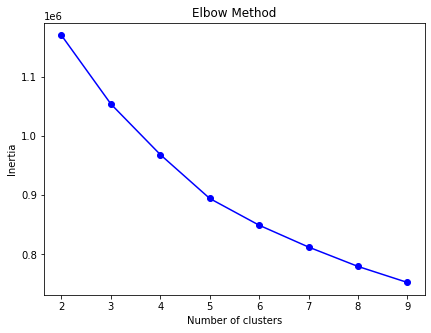

In [20]:

# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 20 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled0)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled0, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
#plt.subplot(1, 2, 2)
#plt.plot(cluster_range, silhouette_scores_list, 'bo-')
#plt.title('Silhouette Scores')
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')

plt.show()

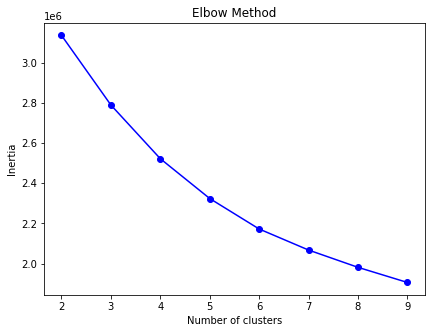

In [21]:

# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 20 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled1)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
#plt.subplot(1, 2, 2)
#plt.plot(cluster_range, silhouette_scores_list, 'bo-')
#plt.title('Silhouette Scores')
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')

plt.show()

In [10]:
# Initialize KMeans and fit to the first subset
kmeans0 = KMeans(n_clusters= 5, n_init=10 , random_state=42)
kmeans0.fit(features_scaled0)

# Add cluster labels to the first subset DataFrame
dfb3_0.loc[:, 'Cluster'] = kmeans0.labels_

# Repeat for the second subset
kmeans1 = KMeans(n_clusters= 6, n_init=10 , random_state=42)
kmeans1.fit(features_scaled1)

dfb3_1.loc[:, 'Cluster'] = kmeans1.labels_ + 5

# Optionally, combine the subsets back together
dfb3 = pd.concat([dfb3_0, dfb3_1])

C:\Users\kearn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\kearn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [25]:
from sklearn.metrics import silhouette_score

# Assuming 'features_scaled' is your scaled feature set and 'kmeans' is your fitted KMeans model
silhouette_avg = silhouette_score(features_scaled0, kmeans0.labels_)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.13680036134131934


In [ ]:
from sklearn.metrics import silhouette_score

# Assuming 'features_scaled' is your scaled feature set and 'kmeans' is your fitted KMeans model
silhouette_avg = silhouette_score(features_scaled1, kmeans1.labels_)
print("The average silhouette_score is :", silhouette_avg)

In [12]:
dfb3.head()

,Date,TaggedPitchType,InducedVertBreak,PlateLocSide,PlateLocHeight,HorzBreak,runsHome,Tilt,League,ExitSpeed,...,RunValue,year,year_2021,year_2022,year_2023,SEC_Game,in_zone,bats_r,throws_r,Cluster
0,2021-02-19,Fastball,15.2,-1.10489,3.32767,-7.7,NaN,11:00,BW,NaN,...,-0.089088,2021,1,0,0,0,0,1,0,2
2,2021-02-19,Fastball,19.0,-1.55110,3.06446,-4.3,NaN,11:30,BW,NaN,...,0.081127,2021,1,0,0,0,0,1,0,2
3,2021-02-19,Fastball,17.2,-1.70759,2.14130,-2.9,NaN,11:45,BW,NaN,...,0.081127,2021,1,0,0,0,0,1,0,0
6,2021-02-19,Fastball,19.9,1.84871,3.18829,-4.0,NaN,11:30,BW,NaN,...,0.081127,2021,1,0,0,0,0,1,0,0
8,2021-02-19,Fastball,20.6,0.92217,4.73855,2.1,NaN,12:15,BW,NaN,...,0.081127,2021,1,0,0,0,0,1,0,0


In [51]:
unique_names_in_cluster= dfb3[dfb3['Cluster'] == 3]['Pitcher'].unique()

print(unique_names_in_cluster)

['Torra, Zachary' 'Grant II, Russell' 'Mayhue, C.J.' ... 'Patton, Myles'
 'Umberger, Grant' 'Scinta, Chris']


In [52]:
len(unique_names_in_cluster)

1178

In [31]:
# Descriptive Statistics of each cluster
selected_columns = ['RelSpeed', 'Extension', 'Cluster']
clustered_data = dfb3[selected_columns]
# 'InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension',
# Descriptive Statistics of each cluster for the selected variables
cluster_description = clustered_data.groupby('Cluster').describe()
print(cluster_description)

         RelSpeed                                                      \
            count       mean       std   min   25%   50%   75%    max   
Cluster                                                                 
0         53633.0  89.616167  2.300192  81.1  87.9  89.5  91.2  100.6   
1         37907.0  84.066790  2.649739  46.7  83.0  84.6  85.7   89.7   
2         54477.0  89.024175  2.242646  78.9  87.5  89.0  90.5   99.2   
3         60735.0  89.411725  2.183217  81.0  87.8  89.3  90.9  101.2   
4         42959.0  87.251910  3.001376  69.7  85.6  87.5  89.3   96.7   
5        118368.0  90.145761  2.520591  75.5  88.5  90.1  91.8  101.7   
6         96178.0  85.925337  2.496388  45.3  84.8  86.4  87.6   92.1   
7        137633.0  90.097152  2.476946  79.9  88.4  90.0  91.7  102.8   
8        139979.0  90.859008  2.418882  79.1  89.1  90.7  92.5  103.6   
9        159870.0  91.838234  2.284621  84.4  90.2  91.7  93.3  101.9   
10        23181.0  84.561399  3.626000  48.0  82.1 

In [17]:
# ANOVA tests
import scipy.stats as stats

features_to_test = ['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension']  # Replace with your actual feature names

anova_results = {}
for feature in features_to_test:
    grouped_data = [dfb3[dfb3['Cluster'] == cluster][feature] for cluster in dfb3['Cluster'].unique()]
    anova_results[feature] = stats.f_oneway(*grouped_data)

for feature, result in anova_results.items():
    print(f"ANOVA test result for {feature}: F-statistic = {result.statistic}, p-value = {result.pvalue}")


ANOVA test result for InducedVertBreak: F-statistic = 95375.56069598085, p-value = 0.0
ANOVA test result for HorzBreak: F-statistic = 631313.6917973444, p-value = 0.0
ANOVA test result for RelSpeed: F-statistic = 71493.70931612237, p-value = 0.0
ANOVA test result for RelHeight: F-statistic = 99716.63839647344, p-value = 0.0
ANOVA test result for RelSide: F-statistic = 662068.3474346884, p-value = 0.0
ANOVA test result for Extension: F-statistic = 63332.166502845794, p-value = 0.0


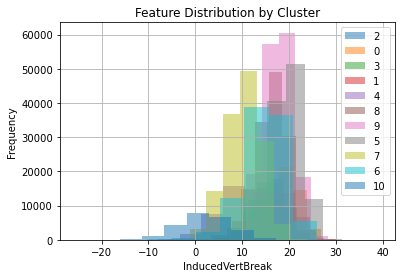

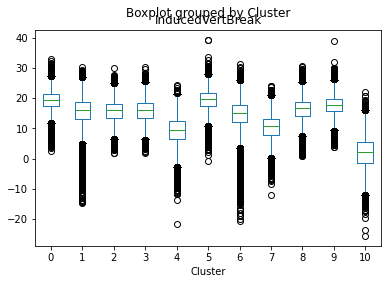

In [18]:
# Histogram
for i in dfb3['Cluster'].unique():
    dfb3[dfb3['Cluster'] == i]['InducedVertBreak'].hist(alpha=0.5)

plt.title('Feature Distribution by Cluster')
plt.xlabel('InducedVertBreak')
plt.ylabel('Frequency')
plt.legend(dfb3['Cluster'].unique())
plt.show()

# Box Plot
dfb3.boxplot(by='Cluster', column=['InducedVertBreak'], grid=False)
plt.show()

In [19]:
grouped = dfb3.groupby('Cluster').mean()
print(grouped[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'throws_r']])

         InducedVertBreak  HorzBreak   RelSpeed  RelHeight   RelSide  \
Cluster                                                                
0               19.358084  -6.919842  89.616167   6.203071 -1.098397   
1               15.692437  -8.855288  84.066790   5.859229 -1.604181   
2               15.664899 -10.598888  89.024175   5.680397 -2.121846   
3               15.772010 -14.254962  89.411725   5.836058 -1.790299   
4                9.150895 -16.296965  87.251910   5.075586 -2.605009   
5               19.270695   5.342070  90.145761   6.239163  0.846727   
6               14.572537   9.127500  85.925337   5.776944  1.572598   
7               10.364410  16.935526  90.097152   5.458543  2.129690   
8               16.380315   9.806866  90.859008   5.776366  1.887918   
9               17.645908  11.849879  91.838234   5.982780  1.627043   
10               1.959022  17.340016  84.561399   4.055593  3.142768   

         Extension  throws_r  
Cluster                       
0

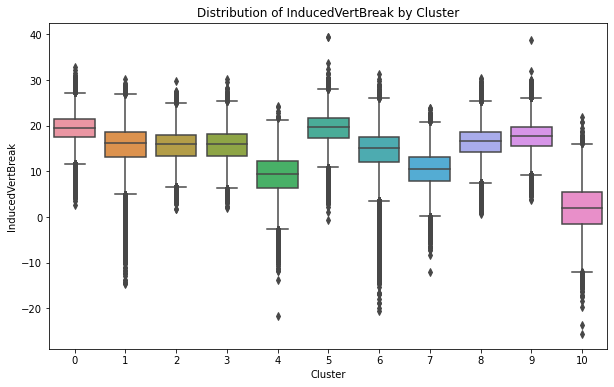

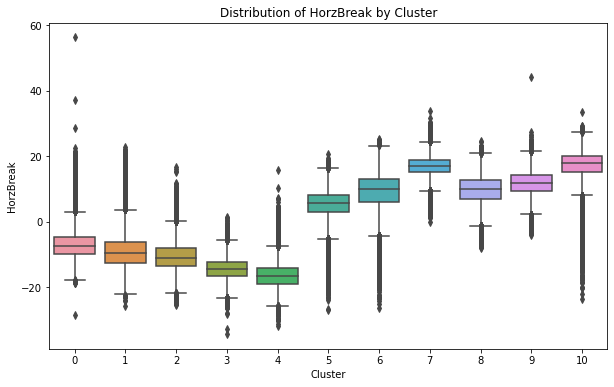

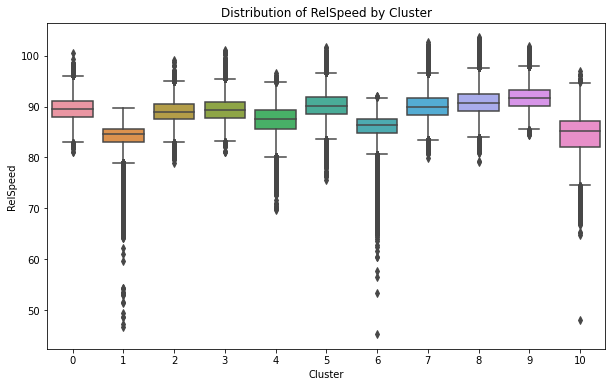

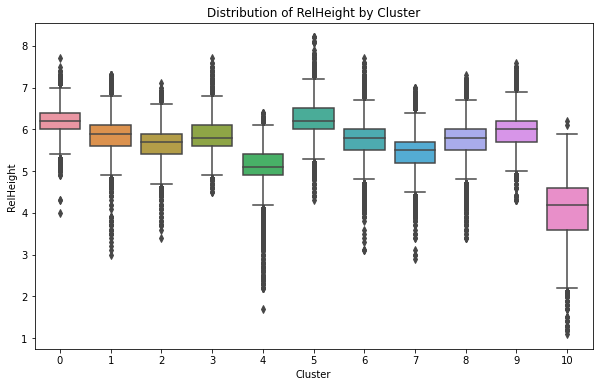

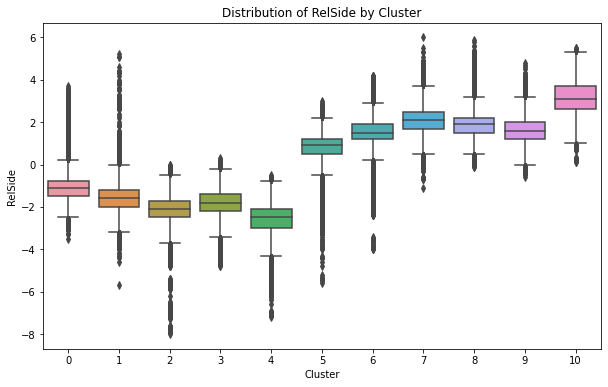

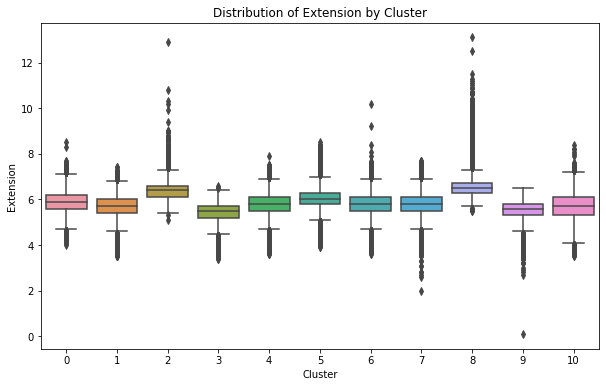

In [112]:
import seaborn as sns
for feature in features0.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=dfb3)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

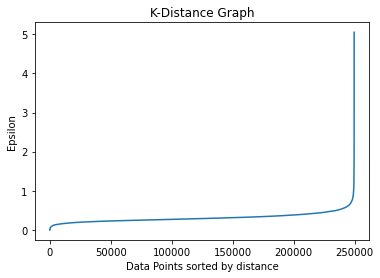

In [21]:
# Nearest Neighbors for DBSCAN CLustering
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples=7
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(features_scaled0)
distances, indices = neighbors_fit.kneighbors(features_scaled0)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("K-Distance Graph")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("Epsilon")
plt.show()

In [22]:
# DBSCAN clustering
from sklearn.cluster import DBSCAN

# DBSCAN clustering
dbscan = DBSCAN(eps=0.55, min_samples=7)  # Adjust these parameters as needed
dbscan_labels = dbscan.fit_predict(features_scaled0)

# Adding the cluster labels to your dataframe
dfb3_0['DBSCAN_Cluster'] = dbscan_labels

# Count the number of points in each cluster
print(dfb3_0['DBSCAN_Cluster'].value_counts())

 0      224927
-1       21712
 103       470
 17        105
 70        105
         ...  
 101         3
 126         3
 8           3
 181         3
 60          2
Name: DBSCAN_Cluster, Length: 185, dtype: int64


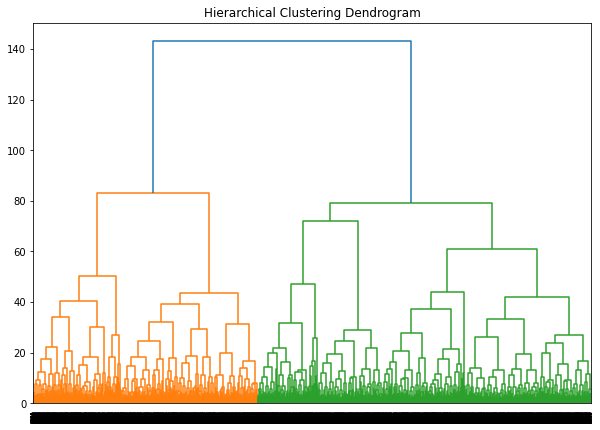

In [32]:
#Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

import numpy as np

# Assume features_scaled0 is a numpy array
num_samples = 10000  # Adjust the sample size as needed
# Ensure num_samples is not more than the number of rows in features_scaled0
num_samples = min(num_samples, features_scaled0.shape[0])

# Randomly choose indices without replacement
sample_indices = np.random.choice(features_scaled0.shape[0], size=num_samples, replace=False)

# Use these indices to create a sample
sample_data = features_scaled0[sample_indices]

# Now you can apply hierarchical clustering
linked = linkage(sample_data, method='ward')

# Plotting the dendrogram (you might want to adjust the figure size for clarity)
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# You can choose the number of clusters based on the dendrogram
#n_clusters = 5  # for example
#agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
#agg_labels = agg_clustering.fit_predict(features_scaled0)

# Adding the cluster labels to your dataframe
#dfb3_0['Hierarchical_Cluster'] = agg_labels

# Count the number of points in each cluster
#print(dfb3_0['Hierarchical_Cluster'].value_counts())


In [33]:
# For Sliders
# Split the data based on 'throws_r' value
dsl3_0 = dsl3[dsl3['throws_r'] == 0]
dsl3_1 = dsl3[dsl3['throws_r'] == 1]

# Features for clustering
features2 = dsl3_0[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']]
features3 = dsl3_1[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']]

# Standardize the features
scaler = StandardScaler()
features_scaled2 = scaler.fit_transform(features2)
features_scaled3 = scaler.fit_transform(features3)


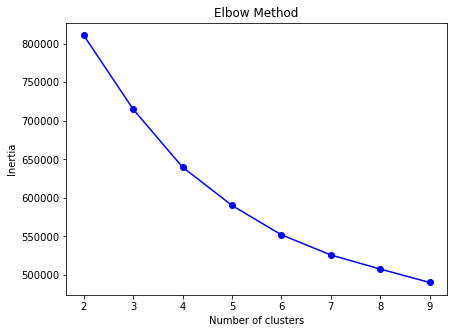

In [114]:

# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 10 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled2)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
#plt.subplot(1, 2, 2)
#plt.plot(cluster_range, silhouette_scores_list, 'bo-')
#plt.title('Silhouette Scores')
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')

plt.show()

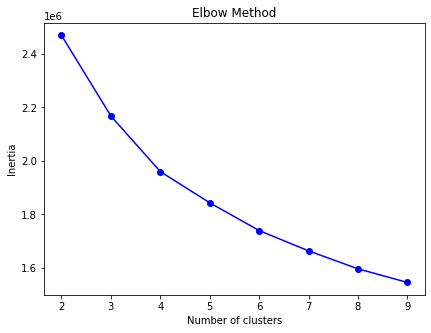

In [115]:
# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 10 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled3)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
#plt.subplot(1, 2, 2)
#plt.plot(cluster_range, silhouette_scores_list, 'bo-')
#plt.title('Silhouette Scores')
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')

plt.show()

In [34]:
# For Sliders
# Initialize KMeans and fit to the first subset
kmeans0 = KMeans(n_clusters= 5, n_init=10 , random_state=42)
kmeans0.fit(features_scaled2)

# Add cluster labels to the first subset DataFrame
dsl3_0.loc[:, 'Cluster'] = kmeans0.labels_

# Repeat for the second subset
kmeans1 = KMeans(n_clusters= 5, n_init=10 , random_state=42)
kmeans1.fit(features_scaled3)

dsl3_1.loc[:, 'Cluster'] = kmeans1.labels_ + 5

# Optionally, combine the subsets back together
dsl3 = pd.concat([dsl3_0, dsl3_1])

C:\Users\kearn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\kearn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [44]:
dsl3['Cluster'].value_counts()

5    123817
7     89817
9     68300
8     60543
2     36426
6     31460
4     28632
0     25260
1     22076
3      5179
Name: Cluster, dtype: int64

In [50]:
len(unique_teams_in_cluster)

902

In [48]:
unique_teams_in_cluster= dsl3[dsl3['Cluster'] == 3]['Pitcher'].unique()

print(unique_teams_in_cluster)

['DeLaite, Trevor' 'Clark, Mat' 'Talley, Brandon' 'Wolfe, Hunter'
 'Zwack, Nick' 'Olson, Trevor ' 'Menard, Chipper' 'Conway, Cory'
 ' Niznik, Noah' 'Olson, Ben' 'Whisenhunt, Carson' 'Hays, Braden'
 'Jones, Nick' 'Aldrich, Jack' 'Knueppel, Keaton' 'Lehrmann, Tyler'
 'Spinney, Austin' 'Dockman, Matthew' 'Khachadourian, Kyle' 'Rich, Keegan'
 'Och, Ryan' 'Gainey, Garrett' 'Gilreath, John' 'Prosecky, Michael'
 'Raymond, Brian' 'McCarthy, Oliver' 'Bowman, Colton ' 'Kuehner, Tate'
 'Mayhue, C.J.' 'Weber, Chris' 'Rollins, Carson ' 'Tuthill, Tyler'
 'Romel, Collin' 'Campbell, Justin' 'Weber, Austin' 'Young, Casey'
 'Bertrand, John Michael' 'Mercer, Will' 'Zimmerman, Jack'
 'Singh, Samrath' 'Shoemake, Dalton' 'Allen, Joshua' 'Madden, Danny'
 'Childress, Jonathan' 'Vetrano, Joe' 'Coon, Charlie' 'Bloebaum, Adam'
 'Goldstein, Charlie' 'Worrell, Sawyer' 'Grice, Caden' 'Paul, Khristian'
 'Harding, Houston' 'Perrin, Austin' 'Kuchmaner, Jake' 'Elliott, Adam'
 'Strickland, Samuel' 'Furman, Maddison' 'He

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming 'features_scaled' is your scaled feature set and 'kmeans' is your fitted KMeans model
silhouette_avg = silhouette_score(features_scaled2, kmeans0.labels_)
print("The average silhouette_score is :", silhouette_avg)

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming 'features_scaled' is your scaled feature set and 'kmeans' is your fitted KMeans model
silhouette_avg = silhouette_score(features_scaled3, kmeans1.labels_)
print("The average silhouette_score is :", silhouette_avg)

In [39]:
# Descriptive Statistics of each cluster
selected_columns = ['hb_fb_diff', 'velo_diff', 'Cluster']
clustered_data = dsl3[selected_columns]
# 'InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension',
# Descriptive Statistics of each cluster for the selected variables
cluster_description = clustered_data.groupby('Cluster').describe()
print(cluster_description)

        hb_fb_diff                                                        \
             count       mean       std        min        25%        50%   
Cluster                                                                    
0          25260.0   7.279669  4.056006   0.039399   4.160601   7.139399   
1          22076.0   7.964509  4.515620   0.039399   4.460601   7.760601   
2          36426.0   3.057067  2.464137   0.039399   1.160601   2.460601   
3           5179.0  18.673054  4.638682   7.939399  15.139399  19.039399   
4          28632.0   3.040696  2.292890   0.039399   1.239399   2.560601   
5         123817.0  10.187051  2.976773   0.039399   8.239399  10.339399   
6          31460.0  14.378302  5.037493   0.039399  10.860601  13.739399   
7          89817.0   7.635363  3.477804   0.039399   5.260601   7.539399   
8          60543.0  15.492463  4.346708   0.039399  12.639399  15.439399   
9          68300.0  19.726611  3.465409  11.639399  17.039399  19.339399   

           

In [36]:
grouped = dsl3.groupby('Cluster').mean()
print(grouped[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'throws_r', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']])

         InducedVertBreak  HorzBreak   RelSpeed  RelHeight   RelSide  \
Cluster                                                                
0              -10.424477  11.844747  74.159786   5.903745 -1.652486   
1               -0.406197  12.556016  75.962629   5.126450 -2.588417   
2               -2.348545   6.019892  78.186770   5.854845 -1.689573   
3                9.249295 -13.633655  80.468816   5.545318 -1.938444   
4                4.148282   3.664180  81.052609   5.686190 -2.061159   
5               -1.153493  -5.063578  80.258421   5.888259  1.586693   
6                1.969739  -8.879390  77.529587   4.680817  2.874733   
7                6.087264  -0.871560  83.727392   5.750333  1.853686   
8              -11.733525 -10.432570  75.880581   5.974856  1.452168   
9               -1.950407 -14.687212  78.544589   5.616290  1.896958   

         Extension  throws_r  velo_diff  ivb_fb_diff  hb_fb_diff  
Cluster                                                           
0

In [40]:
# ANOVA tests
import scipy.stats as stats

features_to_test = ['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']  # Replace with your actual feature names

anova_results = {}
for feature in features_to_test:
    grouped_data = [dsl3[dsl3['Cluster'] == cluster][feature] for cluster in dsl3['Cluster'].unique()]
    anova_results[feature] = stats.f_oneway(*grouped_data)

for feature, result in anova_results.items():
    print(f"ANOVA test result for {feature}: F-statistic = {result.statistic}, p-value = {result.pvalue}")


ANOVA test result for InducedVertBreak: F-statistic = 102393.77675402416, p-value = 0.0
ANOVA test result for HorzBreak: F-statistic = 166900.10709569868, p-value = 0.0
ANOVA test result for RelSpeed: F-statistic = 46068.29427214334, p-value = 0.0
ANOVA test result for RelHeight: F-statistic = 30633.841867748397, p-value = 0.0
ANOVA test result for RelSide: F-statistic = 319633.15584077686, p-value = 0.0
ANOVA test result for Extension: F-statistic = 7049.463809715707, p-value = 0.0
ANOVA test result for velo_diff: F-statistic = 53232.1371680104, p-value = 0.0
ANOVA test result for ivb_fb_diff: F-statistic = 105099.44362314069, p-value = 0.0
ANOVA test result for hb_fb_diff: F-statistic = 111411.35251593655, p-value = 0.0


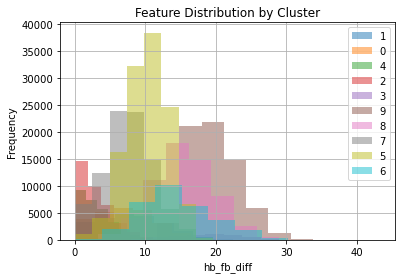

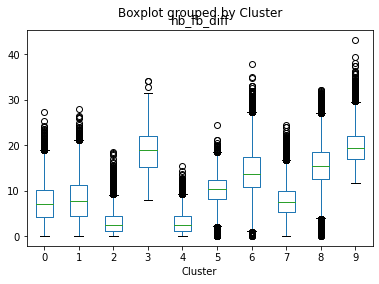

In [41]:
# Histogram
for i in dsl3['Cluster'].unique():
    dsl3[dsl3['Cluster'] == i]['hb_fb_diff'].hist(alpha=0.5)

plt.title('Feature Distribution by Cluster')
plt.xlabel('hb_fb_diff')
plt.ylabel('Frequency')
plt.legend(dsl3['Cluster'].unique())
plt.show()

# Box Plot
dsl3.boxplot(by='Cluster', column=['hb_fb_diff'], grid=False)
plt.show()

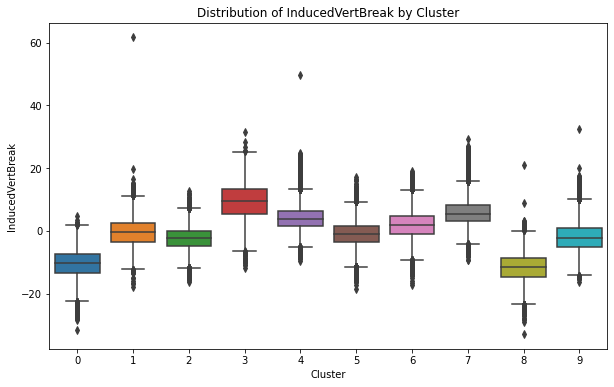

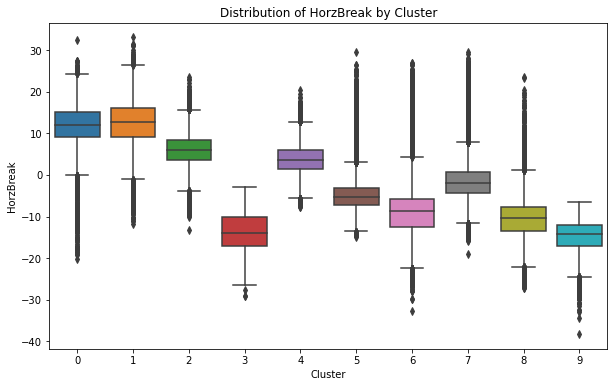

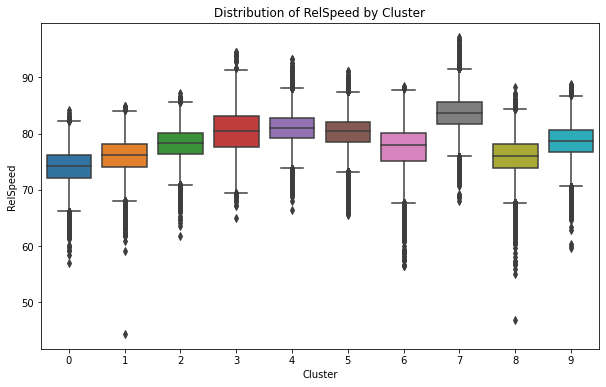

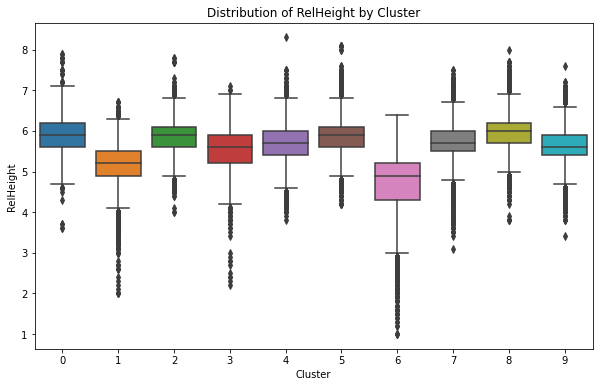

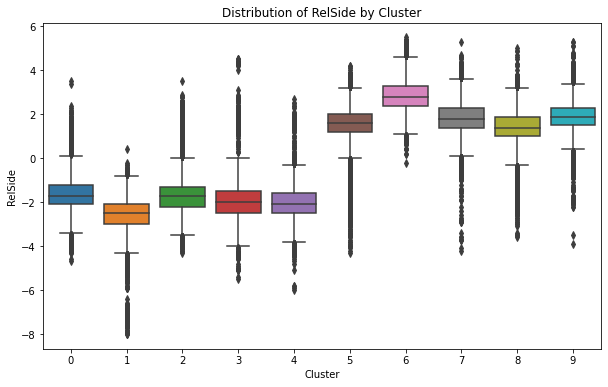

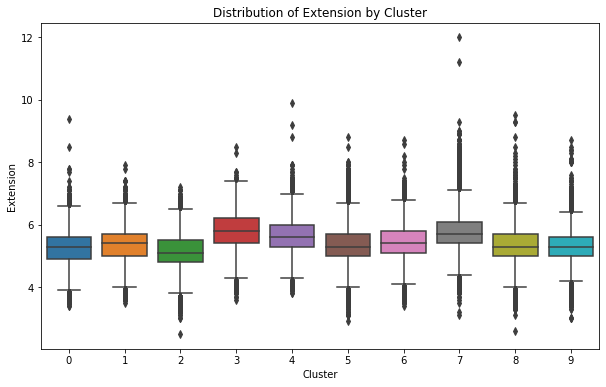

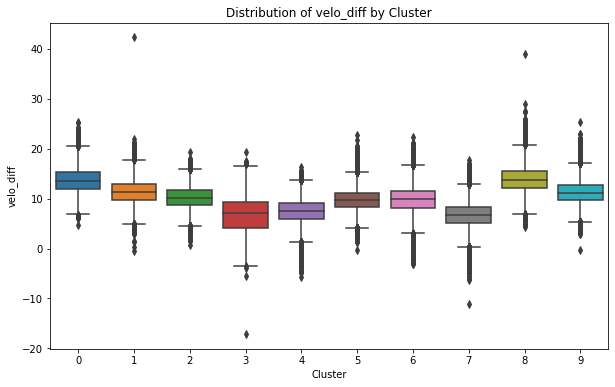

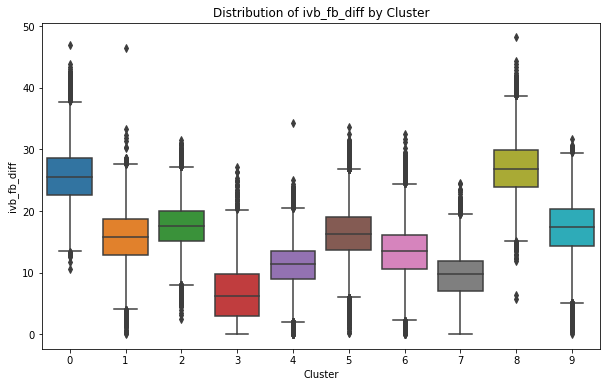

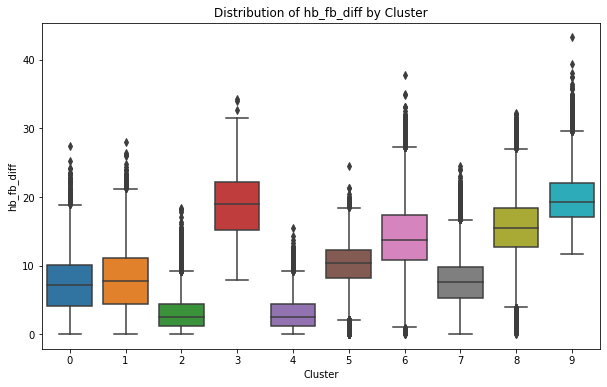

In [43]:
import seaborn as sns

for feature in features2.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=dsl3)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

In [124]:
# For Changeups
# Split the data based on 'throws_r' value
dch3_0 = dch3[dch3['throws_r'] == 0]
dch3_1 = dch3[dch3['throws_r'] == 1]

# Features for clustering
features4 = dch3_0[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']]
features5 = dch3_1[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']]

# Standardize the features
scaler = StandardScaler()
features_scaled4 = scaler.fit_transform(features4)
features_scaled5 = scaler.fit_transform(features5)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

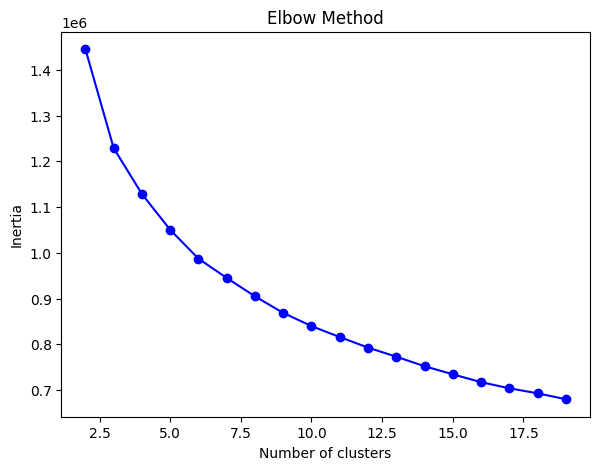

In [ ]:

# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 10 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled4)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
#plt.subplot(1, 2, 2)
#plt.plot(cluster_range, silhouette_scores_list, 'bo-')
#plt.title('Silhouette Scores')
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 10 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled5)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
#plt.subplot(1, 2, 2)
#plt.plot(cluster_range, silhouette_scores_list, 'bo-')
#plt.title('Silhouette Scores')
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')

plt.show()

In [ ]:
# Perform hierarchical clustering
linked = linkage(features_scaled3, method='ward')

# Plot the dendrogram for Hierarchical Clustering
plt.subplot(1, 2, 2)
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()

In [149]:
# For Changeups
# Initialize KMeans and fit to the first subset
kmeans0 = KMeans(n_clusters= 5, n_init=10 , random_state=42)
kmeans0.fit(features_scaled4)

# Add cluster labels to the first subset DataFrame
dch3_0.loc[:, 'Cluster'] = kmeans0.labels_

# Repeat for the second subset
kmeans1 = KMeans(n_clusters= 5, n_init=10 , random_state=42)
kmeans1.fit(features_scaled5)

dch3_1.loc[:, 'Cluster'] = kmeans1.labels_ + 5

# Optionally, combine the subsets back together
dch3 = pd.concat([dch3_0, dch3_1])

In [150]:
dch3['Cluster'].value_counts()

6    39163
9    27506
8    25972
7    23872
0    16442
5    15820
2    13395
3    12848
1    11558
4     4669
Name: Cluster, dtype: int64

In [151]:
centroids0 = kmeans0.cluster_centers_
print(centroids0)
centroids1 = kmeans1.cluster_centers_
print(centroids1)

[[ 3.10146000e-01 -3.10793902e-01  7.88842853e-01  6.90630840e-02
  -7.36787780e-02  1.04981549e-01 -7.80367847e-01 -3.93009213e-01
   3.07089592e-01]
 [-1.09829140e+00 -4.50248364e-01  2.16058597e-01 -9.20525553e-01
  -5.05225464e-01 -1.94328023e-03 -2.20983346e-01  1.14533965e+00
   4.65796172e-01]
 [ 4.72508950e-02 -4.70789167e-01 -8.53713629e-01 -6.69224756e-02
  -1.44460134e-01  1.83396910e-02  8.61608485e-01 -1.35222218e-01
   4.89172697e-01]
 [ 9.74553615e-01  4.31668244e-01 -1.82896165e-01  7.88324276e-01
   6.62091402e-01  2.83779984e-02  1.31037300e-01 -8.42500191e-01
  -5.26428125e-01]
 [-1.18659721e+00  2.37339162e+00 -3.61041787e-01  6.15655117e-02
   1.04828957e-01 -4.95510195e-01  4.63366919e-01  1.25102681e+00
  -2.19101137e+00]]
[[-1.0892681  -1.68620309 -0.39355011  0.21822481 -0.23044954 -0.52713747
   0.4295732   1.13447291 -0.6709614 ]
 [ 0.2175499   0.54999     0.68571294  0.06451193  0.08675114 -0.09518182
  -0.5883586  -0.29435603  0.51157536]
 [-1.06645089  0.5

In [152]:
grouped = dch3.groupby('Cluster').mean()
print(grouped[['InducedVertBreak', 'HorzBreak', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'throws_r', 'velo_diff', 'ivb_fb_diff', 'hb_fb_diff']])

         InducedVertBreak  HorzBreak   RelSpeed  RelHeight   RelSide  \
Cluster                                                                
0               10.315466 -14.788237  82.490780   5.676584 -1.984497   
1                2.509768 -15.690786  80.590500   5.206576 -2.312554   
2                8.842434 -15.830915  77.020179   5.610235 -2.039597   
3               13.989376 -10.004273  79.246552   6.017295 -1.427833   
4                2.020754   2.532855  78.659756   5.672478 -1.849904   
5                1.684874   1.996814  80.258066   5.767630  1.630676   
6                9.008784  16.585640  83.895457   5.687912  1.867148   
7                1.820262  16.564042  81.653179   5.097487  2.350834   
8                9.713233  15.336955  78.318062   5.716560  1.706780   
9               12.879041   8.919418  82.090617   5.962812  1.425853   

         Extension  throws_r  velo_diff  ivb_fb_diff  hb_fb_diff  
Cluster                                                           
0

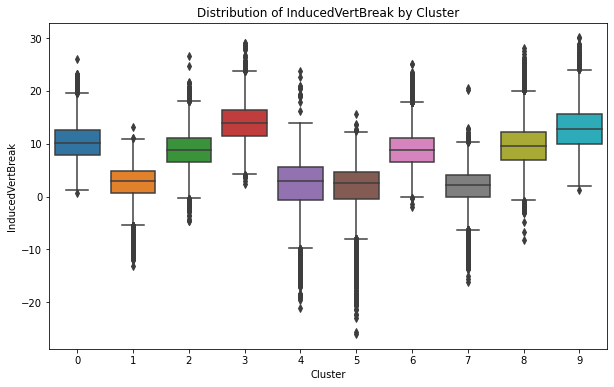

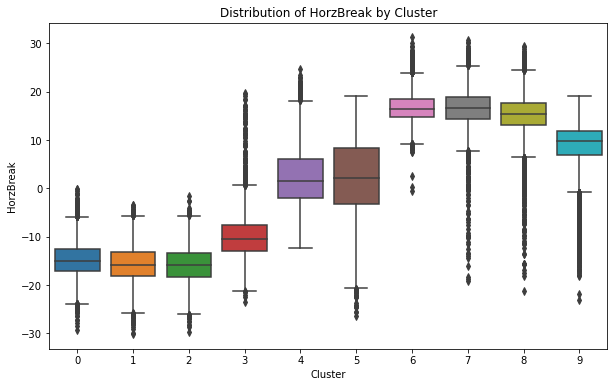

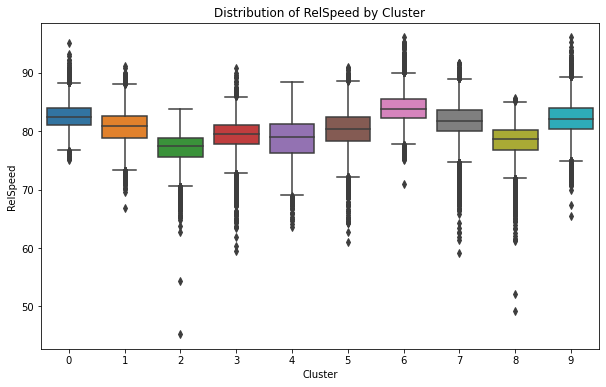

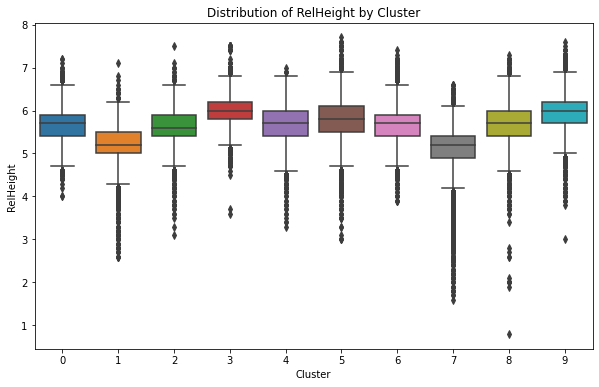

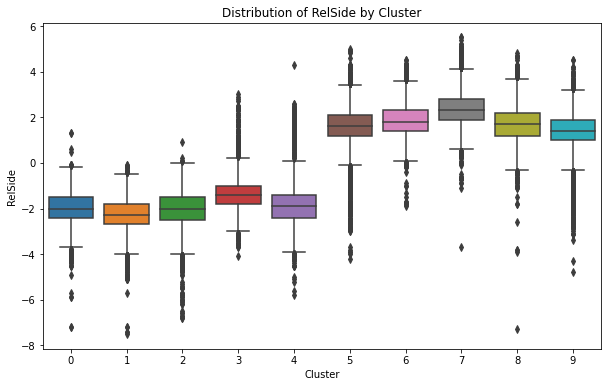

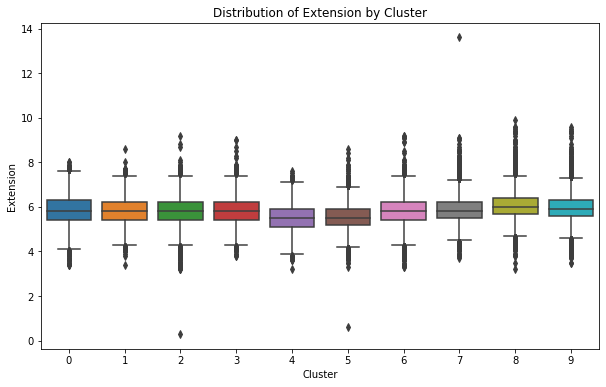

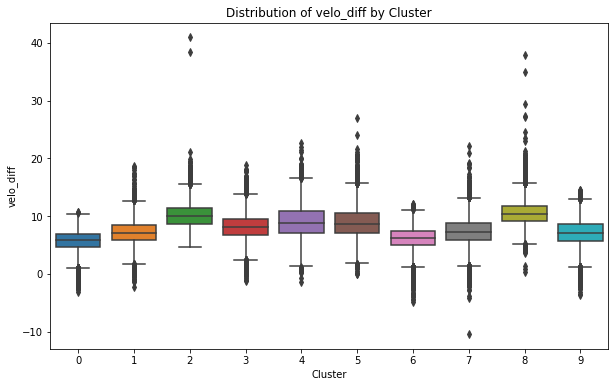

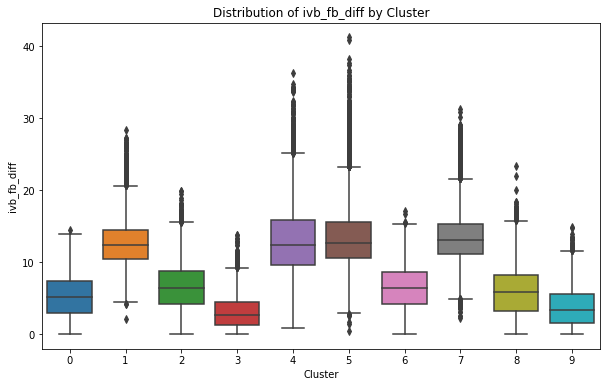

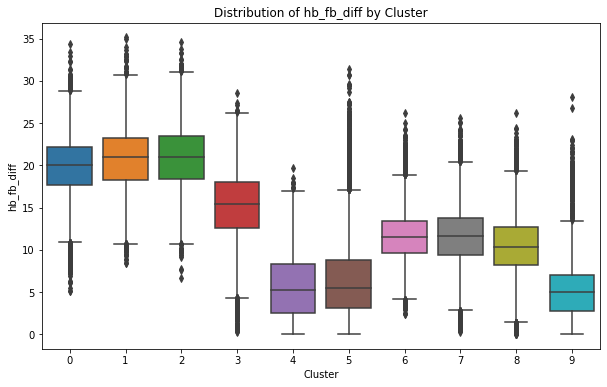

In [153]:
for feature in features4.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=dch3)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

In [131]:
# For Fastballs
# Model For future use not ready yet
# Group by the required columns and calculate the average run value
#grouped_df = dfb3.groupby(['TaggedPitchType', 'Count', 'Cluster', 'Batter'])['Stuffplus'].mean().reset_index(name='AveragexRV')

#X = pd.get_dummies(grouped_df.drop('AveragexRV', axis=1))
#y = grouped_df['AveragexRV']

In [ ]:
# Future Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

In [ ]:
# To predict, create a feature vector that matches the trained model's expectations
# For example:
example_features = pd.get_dummies(grouped_df.drop('AveragexRV', axis=1)).iloc[0].to_frame().T

# Predict
predicted_run_value = model.predict(example_features)

print(f"Predicted Average Run Value: {predicted_run_value[0]}")

In [134]:
# See a batter against different clusters in different counts (Higher the number the worse the hitter was)
def get_batter_performance(batter_name, df):
    """
    Generates a table for the specified batter showing the average Stuffplus for each pitcher cluster and count.

    :param batter_name: Name of the batter.
    :param df: DataFrame containing the baseball data.
    :return: DataFrame filtered for the specified batter.
    """
    # Create the pivot table
    pivot_table = pd.pivot_table(df, values='Stuffplus',
                                 index=['Batter', 'Count'],
                                 columns=['Cluster'],
                                 aggfunc='mean').reset_index()

    # Filter for the specific batter
    specific_batter_data = pivot_table[pivot_table['Batter'] == batter_name]

    # Reset index for a cleaner look
    specific_batter_data.reset_index(drop=True, inplace=True)

    specific_batter_data = specific_batter_data.round(4)

    return specific_batter_data


In [135]:
# Example for Fastball
result_table = get_batter_performance('Crews, Dylan', dfb3)
print(result_table)

Cluster        Batter Count           0           1           2           3  \
0        Crews, Dylan   0-0  129.468506   47.844601  100.683998   99.742897   
1        Crews, Dylan   0-1  142.442703   66.321198  120.275803  143.529999   
2        Crews, Dylan   0-2  129.480698         NaN   85.162300  110.777802   
3        Crews, Dylan   1-0  106.351799   42.103001  110.162903  100.002296   
4        Crews, Dylan   1-1  123.491699   66.035103   88.289398   96.884697   
5        Crews, Dylan   1-2  135.033096         NaN  102.176498  110.760300   
6        Crews, Dylan   2-0  110.872101   55.203701  101.665199  117.321800   
7        Crews, Dylan   2-1  103.764099   86.457001  121.883400   98.044998   
8        Crews, Dylan   2-2  102.014397   60.520500   95.960999   91.847900   
9        Crews, Dylan   3-0  133.868500  111.362801         NaN   74.398300   
10       Crews, Dylan   3-1  133.596405   59.523899  104.498100   28.223600   
11       Crews, Dylan   3-2  105.488701   40.950199 

In [136]:
# Example For Slider
result_table2 = get_batter_performance('Crews, Dylan', dsl3)
print(result_table2)

Cluster        Batter Count           0           1           2           3  \
0        Crews, Dylan   0-0   58.356602   87.108597   99.905602   16.677500   
1        Crews, Dylan   0-1   92.742401   94.360100   96.746902         NaN   
2        Crews, Dylan   0-2  118.702797         NaN   95.265999         NaN   
3        Crews, Dylan   1-0   79.769798   73.117699  100.087196         NaN   
4        Crews, Dylan   1-1   26.225401   22.577200   98.394997         NaN   
5        Crews, Dylan   1-2         NaN  102.822800   91.827904         NaN   
6        Crews, Dylan   2-0   78.021400  113.481903  123.927498         NaN   
7        Crews, Dylan   2-1   35.091000  -13.325500  111.688202  121.529701   
8        Crews, Dylan   2-2   51.000198  132.165298   63.977901         NaN   
9        Crews, Dylan   3-0         NaN         NaN         NaN         NaN   
10       Crews, Dylan   3-1         NaN         NaN  103.880302         NaN   
11       Crews, Dylan   3-2   37.080399         NaN 

In [154]:
# Example For Changeup
result_table3 = get_batter_performance('Crews, Dylan', dch3)
print(result_table3)

Cluster        Batter Count           0           1           2           3  \
0        Crews, Dylan   0-0  106.614899  105.582603  109.334198  114.345497   
1        Crews, Dylan   0-1  111.585701  106.987198    9.593200  106.310097   
2        Crews, Dylan   0-2   82.090202   26.955900         NaN   96.243599   
3        Crews, Dylan   1-0  109.896004  116.191704  101.009399  108.361000   
4        Crews, Dylan   1-1  108.421700  111.001297         NaN  130.379807   
5        Crews, Dylan   1-2   83.447098  108.700699  106.603600         NaN   
6        Crews, Dylan   2-0   87.856499  114.248497  117.743401  129.907593   
7        Crews, Dylan   2-1   69.545403         NaN  164.628906  100.622101   
8        Crews, Dylan   2-2  105.258003   92.317398  176.598999         NaN   
9        Crews, Dylan   3-0         NaN         NaN         NaN  166.840607   
10       Crews, Dylan   3-1         NaN         NaN  119.704498  152.960297   
11       Crews, Dylan   3-2  143.980194  120.527901 

In [138]:
# Input Pitcher, Hitter, and Count and see the xRV for Fastball
def get_hitter_performance_vs_pitcher_cluster(df, pitcher_name, hitter_name, count):
    """
    Function to get the performance of a hitter against a specific pitcher cluster in a specific count.

    :param df: DataFrame with pitcher, hitter, and cluster data.
    :param pitcher_name: Name of the pitcher.
    :param hitter_name: Name of the hitter.
    :param count: The count (e.g., "0-1", "2-2") in the game.
    :return: DataFrame showing the hitter's performance.
    """
    # Create a pivot table within the function
    pivot_table = pd.pivot_table(df, values='Stuffplus',
                                 index=['Batter', 'Count'],
                                 columns=['Cluster'],
                                 aggfunc='mean')

    # Identify the cluster of the given pitcher
    pitcher_cluster = df[df['Pitcher'] == pitcher_name]['Cluster'].iloc[0]

    # Initialize an empty DataFrame to hold the result
    hitter_performance_df = pd.DataFrame(columns=[pitcher_name, hitter_name, count, f'Stuffplus_cluster_{pitcher_cluster}'])

    # Check if the hitter and count exist in the pivot table
    if (hitter_name, count) in pivot_table.index:
        # Filter the pivot table for the given hitter and count
        hitter_performance = pivot_table.loc[(hitter_name, count), pitcher_cluster]

        # Check if the hitter_performance is a Series or a single value
        if isinstance(hitter_performance, pd.Series):
            # Convert the Series object to a DataFrame for better visualization
            hitter_performance_df = hitter_performance.to_frame().transpose()
            # Set column names
            hitter_performance_df.columns = [f'FB-Stuff-Cluster: {cluster}' for cluster in hitter_performance_df.columns]
        else:
            # If it's a single value, create a DataFrame with the value
            hitter_performance_df = pd.DataFrame([[pitcher_name, hitter_name, count, hitter_performance]],
                                                 columns=['Pitcher', 'Batter', 'Count', f'FB-Stuff-Cluster: {pitcher_cluster}'])
    else:
        # If the hitter and count combination doesn't exist, set Stuffplus to None
        hitter_performance_df.loc[0] = [pitcher_name, hitter_name, count, None]

    return hitter_performance_df


In [139]:
# Example usage of the function With Fastball:
result = get_hitter_performance_vs_pitcher_cluster(dfb3, 'Dettmer, Nathan', 'Crews, Dylan', '3-0')
print(result)

           Pitcher        Batter Count  FB-Stuff-Cluster: 5
0  Dettmer, Nathan  Crews, Dylan   3-0           125.962608


In [140]:
# Input Pitcher, Hitter, and Count and see the xRV For Slider
def get_hitter_performance_vs_pitcher_cluster_SL(df, pitcher_name, hitter_name, count):
    """
    Function to get the performance of a hitter against a specific pitcher cluster in a specific count.

    :param df: DataFrame with pitcher, hitter, and cluster data.
    :param pitcher_name: Name of the pitcher.
    :param hitter_name: Name of the hitter.
    :param count: The count (e.g., "0-1", "2-2") in the game.
    :return: DataFrame showing the hitter's performance.
    """
    # Create a pivot table within the function
    pivot_table = pd.pivot_table(df, values='Stuffplus',
                                 index=['Batter', 'Count'],
                                 columns=['Cluster'],
                                 aggfunc='mean')

    # Identify the cluster of the given pitcher
    pitcher_cluster = df[df['Pitcher'] == pitcher_name]['Cluster'].iloc[0]

    # Initialize an empty DataFrame to hold the result
    hitter_performance_df = pd.DataFrame(columns=[pitcher_name, hitter_name, count, f'Stuffplus_cluster_{pitcher_cluster}'])

    # Check if the hitter and count exist in the pivot table
    if (hitter_name, count) in pivot_table.index:
        # Filter the pivot table for the given hitter and count
        hitter_performance = pivot_table.loc[(hitter_name, count), pitcher_cluster]

        # Check if the hitter_performance is a Series or a single value
        if isinstance(hitter_performance, pd.Series):
            # Convert the Series object to a DataFrame for better visualization
            hitter_performance_df = hitter_performance.to_frame().transpose()
            # Set column names
            hitter_performance_df.columns = [f'SL-Stuff-Cluster: {cluster}' for cluster in hitter_performance_df.columns]
        else:
            # If it's a single value, create a DataFrame with the value
            hitter_performance_df = pd.DataFrame([[pitcher_name, hitter_name, count, hitter_performance]],
                                                 columns=['Pitcher', 'Batter', 'Count', f'SL-Stuff-Cluster: {pitcher_cluster}'])
    else:
        # If the hitter and count combination doesn't exist, set Stuffplus to None
        hitter_performance_df.loc[0] = [pitcher_name, hitter_name, count, None]

    return hitter_performance_df


In [141]:
# Example usage of the function With Slider:
result = get_hitter_performance_vs_pitcher_cluster_SL(dsl3, 'Dettmer, Nathan', 'Crews, Dylan', '1-0')
print(result)

           Pitcher        Batter Count  SL-Stuff-Cluster: 8
0  Dettmer, Nathan  Crews, Dylan   1-0            66.353531


In [142]:
# Input Pitcher, Hitter, and Count and see the xRV For Changeup
def get_hitter_performance_vs_pitcher_cluster_CH(df, pitcher_name, hitter_name, count):
    """
    Function to get the performance of a hitter against a specific pitcher cluster in a specific count.

    :param df: DataFrame with pitcher, hitter, and cluster data.
    :param pitcher_name: Name of the pitcher.
    :param hitter_name: Name of the hitter.
    :param count: The count (e.g., "0-1", "2-2") in the game.
    :return: DataFrame showing the hitter's performance.
    """
    # Create a pivot table within the function
    pivot_table = pd.pivot_table(df, values='Stuffplus',
                                 index=['Batter', 'Count'],
                                 columns=['Cluster'],
                                 aggfunc='mean')

    # Identify the cluster of the given pitcher
    pitcher_cluster = df[df['Pitcher'] == pitcher_name]['Cluster'].iloc[0]

    # Initialize an empty DataFrame to hold the result
    hitter_performance_df = pd.DataFrame(columns=[pitcher_name, hitter_name, count, f'Stuffplus_cluster_{pitcher_cluster}'])

    # Check if the hitter and count exist in the pivot table
    if (hitter_name, count) in pivot_table.index:
        # Filter the pivot table for the given hitter and count
        hitter_performance = pivot_table.loc[(hitter_name, count), pitcher_cluster]

        # Check if the hitter_performance is a Series or a single value
        if isinstance(hitter_performance, pd.Series):
            # Convert the Series object to a DataFrame for better visualization
            hitter_performance_df = hitter_performance.to_frame().transpose()
            # Set column names
            hitter_performance_df.columns = [f'CH-Stuff-Cluster: {cluster}' for cluster in hitter_performance_df.columns]
        else:
            # If it's a single value, create a DataFrame with the value
            hitter_performance_df = pd.DataFrame([[pitcher_name, hitter_name, count, hitter_performance]],
                                                 columns=['Pitcher', 'Batter', 'Count', f'CH-Stuff-Cluster: {pitcher_cluster}'])
    else:
        # If the hitter and count combination doesn't exist, set Stuffplus to None
        hitter_performance_df.loc[0] = [pitcher_name, hitter_name, count, None]

    return hitter_performance_df

In [155]:
# Example usage of the function With Changeup:
result = get_hitter_performance_vs_pitcher_cluster_CH(dch3, 'Dettmer, Nathan', 'Crews, Dylan', '1-0')
print(result)

           Pitcher        Batter Count  CH-Stuff-Cluster: 9
0  Dettmer, Nathan  Crews, Dylan   1-0            67.883614


In [156]:
def get_hitter_performance_vs_pitcher(df_dict, pitch_types, pitcher_name, hitter_name, count):
    results = []

    for pitch_type in pitch_types:
        df = df_dict.get(pitch_type)
        if df is not None:
            pivot_table = pd.pivot_table(df, values='Stuffplus',
                                         index=['Batter', 'Count'],
                                         columns=['Cluster'],
                                         aggfunc='mean')
            pitcher_cluster = df[df['Pitcher'] == pitcher_name]['Cluster'].iloc[0]

            if (hitter_name, count) in pivot_table.index:
                hitter_performance = pivot_table.loc[(hitter_name, count), pitcher_cluster]
                results.append({
                    'Pitcher': pitcher_name, 
                    'Batter': hitter_name, 
                    'Count': count, 
                    'PitchType': pitch_type, 
                    'Stuffplus': hitter_performance
                })

    return pd.DataFrame(results)

In [157]:
df_dict = {'Fastball': dfb3, 'Slider': dsl3, 'Changeup': dch3}
result = get_hitter_performance_vs_pitcher(df_dict, ['Fastball', 'Slider', 'Changeup'], 'Dettmer, Nathan', 'Crews, Dylan', '2-0')
print(result)

           Pitcher        Batter Count PitchType   Stuffplus
0  Dettmer, Nathan  Crews, Dylan   2-0  Fastball  127.556580
1  Dettmer, Nathan  Crews, Dylan   2-0    Slider   81.663162
2  Dettmer, Nathan  Crews, Dylan   2-0  Changeup   37.105072
